# Comparison of Least Squares, Maximum Likelihood, and Bayesian Inference

## Introduction

Notebook that illustrates and compares model fitting to histograms with least squares and fitting to observations (events) with maximum likelihood estimation (MLE)

In [7]:
from scipy.stats import distributions
import numpy as np
import matplotlib.pyplot as plt
from lmfit import models
import pandas as pd

In [2]:
# define parameters

# peak function
peak_location = 2
peak_width = 1
xrange = [-2,6]

# events
nevents = 1000

# histogram
nbins = 25

In [3]:
# define model

reference_model = distributions.norm(peak_location, peak_width) # gaussian located at 2 and with width 1 

In [4]:
xgrid = np.linspace(*xrange)

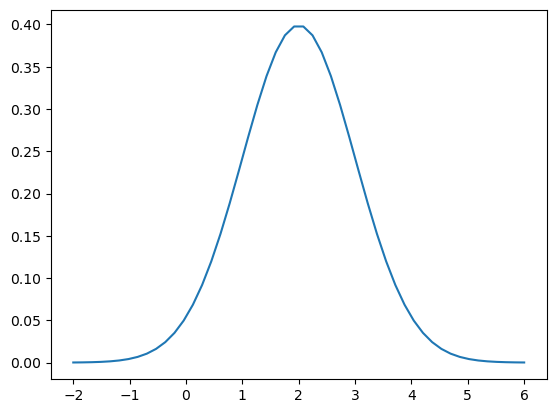

In [5]:
plt.plot(xgrid, reference_model.pdf(xgrid))  # plot the probability distribution

In [6]:
# Generate random events from the model distribution 
np.random.seed(33)
events = reference_model.rvs(nevents) # not all events may fall in the range we are looking at

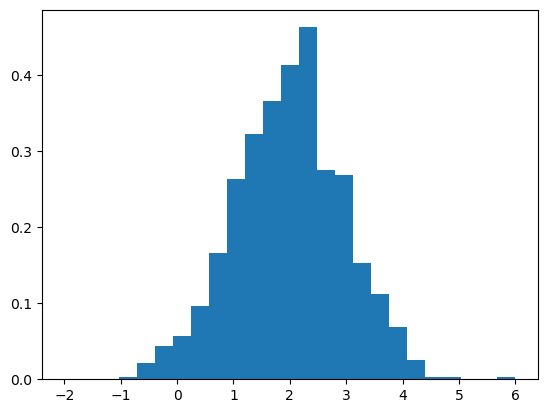

In [7]:
# plot probability density of events with histogram
hist = plt.hist(events, range=xrange, bins=nbins, density=True)

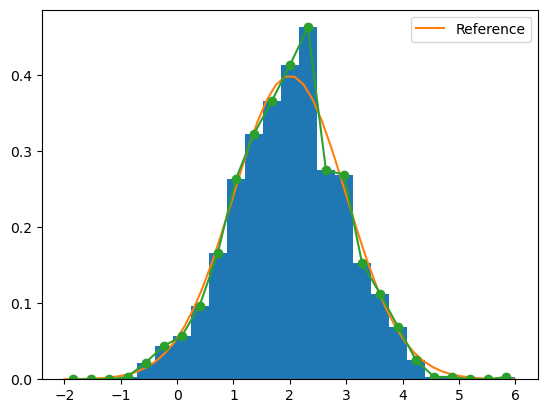

In [8]:
# convert to line plot
xi = 0.5*(hist[1][1:]+hist[1][:-1])

hist = plt.hist(events, range=xrange, bins=nbins, density=True)
plt.plot(xgrid, reference_model.pdf(xgrid), label='Reference') # reference model
plt.plot(xi, hist[0], '-o',)  # line plot of histogram
plt.legend() 

### Traditional way

Finding best parameters by fitting to probability density with least squares 

In [9]:
fit_model = models.GaussianModel()

In [10]:
parameters = fit_model.fit(hist[0], x=xi).values

In [11]:
parameters

{'amplitude': 0.994746477649255,
 'center': 2.0070510667891006,
 'sigma': 0.9570046603477631,
 'fwhm': 2.2535737142801198,
 'height': 0.4146755644492719}

In [12]:
lse_model = distributions.norm(loc=parameters['center'], scale=parameters['sigma'])

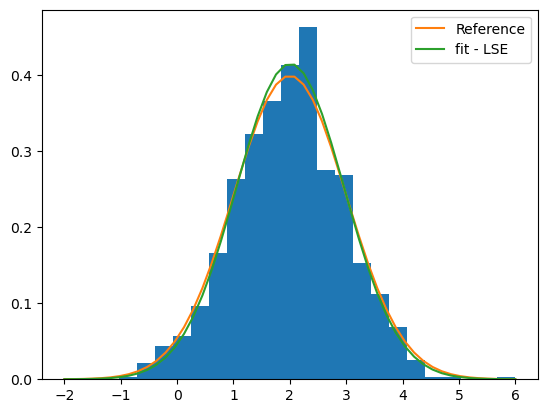

In [13]:
A = parameters['amplitude']
plt.hist(events, range=xrange, bins=nbins, density=True)
plt.plot(xgrid, reference_model.pdf(xgrid), label='Reference')
plt.plot(xgrid, A*lse_model.pdf(xgrid), label='fit - LSE')
plt.legend()

### Maximum Likelihood Estimation

We don't make a histogram, but fit directly to the events using MLE

In [14]:
params = distributions.norm.fit(events)   # the 'raw' events are used and no additional parameters such as range, bin width etc are needed
mle_model = distributions.norm(*params)

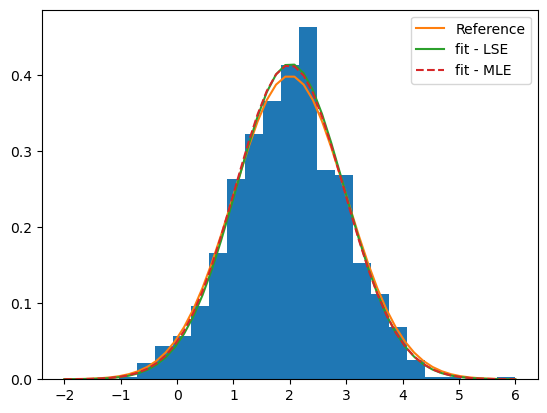

In [15]:
plt.hist(events, range=xrange, bins=nbins, density=True)
plt.plot(xgrid, reference_model.pdf(xgrid), label='Reference')
plt.plot(xgrid, A*lse_model.pdf(xgrid), label='fit - LSE')
plt.plot(xgrid, mle_model.pdf(xgrid), linestyle='dashed', label='fit - MLE')
plt.legend()

In [16]:
def optimal_nbins(events, xrange):
    """
    Calculate optimal number of bins from Freedman-Diaconis rule
    https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
    """
    iqr = np.subtract(*np.percentile(events, [75, 25]))
    return int((xrange[1] - xrange[0])*len(events)**(1/3)/(2*iqr))


def compare(reference_model, mle_fit_model, lse_fit_model, nevents, xrange, seed=None, 
            nbins=None, legend=True, model_plot=True):  # Can toggle legens and plot for efficiency reasons
    xgrid = np.linspace(*xrange, 2000)
    if seed is not None:
        np.random.seed(seed)
    events = reference_model.rvs(nevents)  # not all events may fall in the range 'xrange'
    if nbins is None:
        nbins = optimal_nbins(events, xrange)
    if model_plot==True:
        hist = plt.hist(events, range=xrange, bins=nbins, density=True)   
    else:
        hist = np.histogram(events, range=xrange, bins=nbins, density=True)
    xi = 0.5*(hist[1][1:]+hist[1][:-1])
    lse_params = lse_fit_model.fit(data=hist[0], x=xi).values
    lse_model = mle_fit_model(loc=lse_params['center'], scale=lse_params['sigma'])
    mle_params = mle_fit_model.fit(events)  
    mle_model = mle_fit_model(*mle_params)
    if model_plot==True:
        plt.plot(xgrid, reference_model.pdf(xgrid), label='Reference')
        plt.plot(xgrid, lse_model.pdf(xgrid), linestyle='dashed', label='fit - LSE')
        plt.plot(xgrid, mle_model.pdf(xgrid), linestyle='dashed', label='fit - MLE')
        if legend:
            plt.legend()
    return {'loc_lse' : lse_params['center'], 
            'scale_lse': lse_params['sigma'], 
            'loc_mle': mle_params[0], 
            'scale_mle' : mle_params[1]
           }
    
    

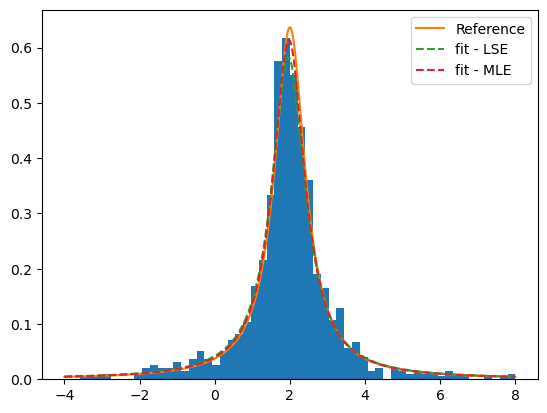

In [17]:
mle_fit_model = distributions.cauchy
lse_fit_model = models.LorentzianModel()
reference_model = mle_fit_model(loc=2, scale=0.5)

params = compare(reference_model, mle_fit_model, lse_fit_model, nevents=nevents, xrange=[-4,8], 
                 seed=333)

In [18]:
def compare_cauchy(nevents, loc=2, scale=1.5, xrange=[-8,12], seed=None, nbins=None, 
                   legend=False, model_plot=False):
    mle_fit_model = distributions.cauchy
    lse_fit_model = models.LorentzianModel()
    reference_model = mle_fit_model(loc=loc, scale=scale)
    parameters = compare(reference_model, mle_fit_model, lse_fit_model, nevents=nevents, xrange=xrange, 
                         nbins=nbins, seed=seed, legend=legend, model_plot=model_plot)
    return parameters

### Convergence as function of numbers of events

<AxesSubplot: >

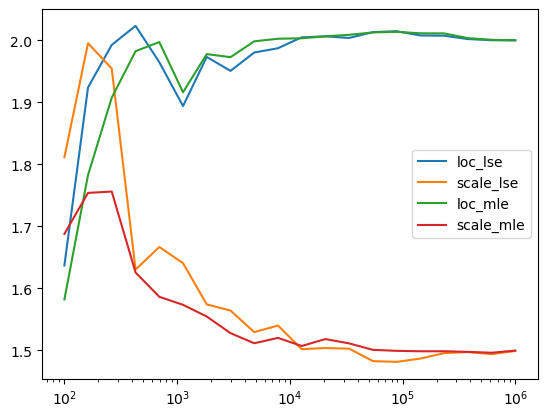

In [19]:
# using the same seed is the same as using the first n number of events from a long series, albeit less efficient

data = {nevents: compare_cauchy(nevents, seed=333, model_plot=False) for nevents in [int(n) for n in np.logspace(2, 6, 20)]}

pd_data = pd.DataFrame(data).T

pd_data.plot(logx=True)

### Variance

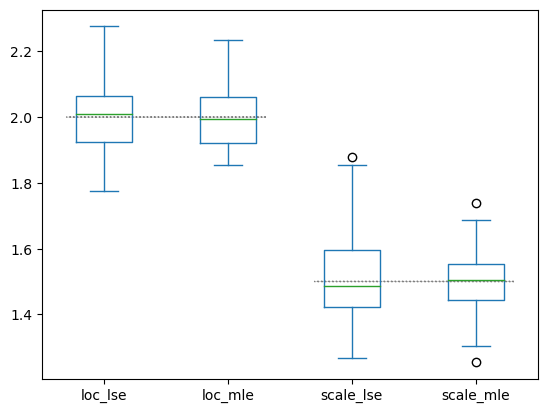

In [20]:
# Run multiple fittings with same number of events but different seeds

nruns = 50
nevents = 500

np.random.seed(0)
seeds = np.random.randint(0, high=10**4, size=nruns)

data = {seed: compare_cauchy(nevents=nevents, seed=seed, model_plot=False) for seed in seeds}

pd_data = pd.DataFrame(data).T


ax = pd_data[['loc_lse', 'loc_mle', 'scale_lse', 'scale_mle']].plot.box()
ax.arrow(0.7, 2, 1.6, 0, linestyle='dotted', color='gray')
ax.arrow(2.7, 1.5, 1.6, 0, linestyle='dotted', color='gray')


In [21]:
pd_data.mean()

loc_lse      1.995869
scale_lse    1.510453
loc_mle      1.998763
scale_mle    1.500496
dtype: float64

In [22]:
pd_data.std()

loc_lse      0.105284
scale_lse    0.147276
loc_mle      0.093722
scale_mle    0.098722
dtype: float64

### Variance as function on number of events

In [23]:
nruns = 50

np.random.seed(0)
seeds = np.random.randint(0, high=10**4, size=nruns)

def get_variance(nevents):
    data = pd.DataFrame({seed: compare_cauchy(nevents=nevents, seed=seed) for seed in seeds})
    return data.mean(axis=1), data.std(axis=1)

In [24]:
nevents_series = [int(n) for n in np.logspace(2, 6, 20)]

results = {nevents: get_variance(nevents) for nevents in nevents_series}

means = {nevents: res[0] for nevents, res in results.items()}
pd_means = pd.DataFrame(means).T

pd_means.head()

,loc_lse,scale_lse,loc_mle,scale_mle
100,2.027569,1.561010,2.018686,1.516664
162,1.984465,1.534046,2.019084,1.493662
263,2.006400,1.489481,2.016052,1.471837
428,1.991015,1.500210,1.991849,1.491263
695,2.001209,1.511978,2.003099,1.506007


In [25]:
stds  = {nevents: res[1] for nevents, res in results.items()}
pd_stds = pd.DataFrame(stds).T
pd_stds.head()

,loc_lse,scale_lse,loc_mle,scale_mle
100,0.258379,0.326915,0.232304,0.247443
162,0.212296,0.259892,0.190471,0.179813
263,0.183140,0.187619,0.157553,0.134495
428,0.119465,0.156102,0.106675,0.113132
695,0.091667,0.142182,0.080421,0.084542


In [26]:
def get_data_for_plot(key):
    x = pd_means.index.array
    y = pd_means[key].array
    dy = pd_stds[key].array
    return (x, y), (x, y - 2*dy, y + 2*dy)

def variance_plot(key, ax):
    ax.set_xscale('log')
    line, fill = get_data_for_plot(key)
    ax.fill_between(*fill, alpha=0.25)
    ax.plot(*line)



Text(0.02, 0.5, 'parameters')

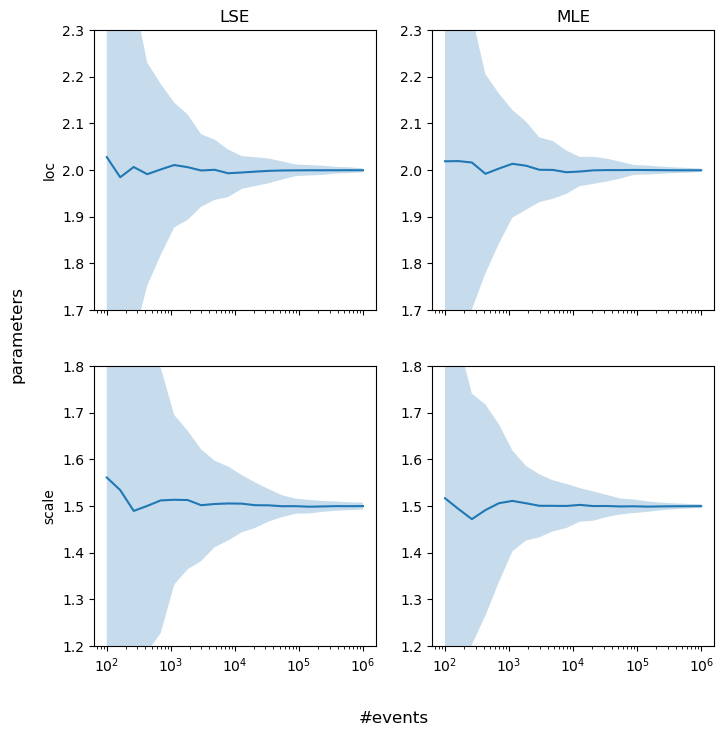

In [27]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(8, 8))

axs[0,0].set_ylim(1.7, 2.3)
axs[0,1].set_ylim(1.7, 2.3)
axs[1,0].set_ylim(1.2, 1.8)
axs[1,1].set_ylim(1.2, 1.8)

axs[0,0].set_title("LSE")
axs[0,1].set_title("MLE")

axs[0,0].set_ylabel("loc")
axs[1,0].set_ylabel("scale")


variance_plot('loc_lse', axs[0,0])
variance_plot('loc_mle', axs[0,1])
variance_plot('scale_lse', axs[1,0])
variance_plot('scale_mle', axs[1,1])

fig.supxlabel('#events')
fig.supylabel('parameters')

# Using SANS-like data

In order to make this work in the SANS regime, we need to use the EMTK generator which only generates events within a specific x-range, otherwise you get both sides of the curve with x < 0 and x > 0.

Secondly, we need to constrain the SciPy MLE cauchy curve to have the location position at x=0.0 otherwise it goes goofy.  The same will be done for the LSE model, to see how that reduces the error bar difference.

/Users/phillipbentley/Code/python/mle/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in scalar multiply
  Lhat = muhat - Shat*mu


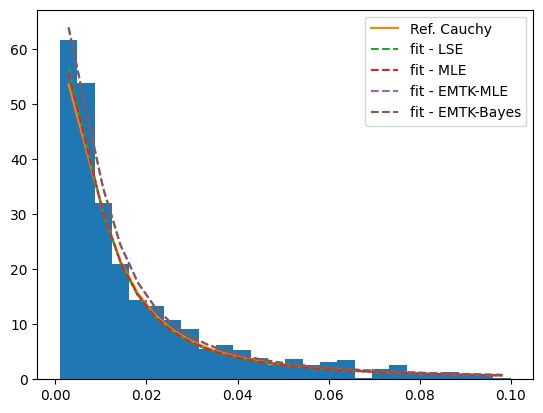

In [4]:
#from scipy.stats import distributions
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from lmfit import models
import pandas as pd

import emtk

# peak function
peak_location = 0.0
peak_width = 1.0 / 90.0
setxrange = [0.001,0.1]

# events
nevents = 1000

# histogram
nbins = 25


def spGenerator(themodel, nevents, xrange):
    '''
    Generates random events from the given scipy model object 
    Guarantees nevents within the given xrange
    Returns numpy array of x values generated by the model.
    
    This might be SLOOOOW if your xrange is not sensible.

    '''
    
    events = themodel.rvs(nevents)
    xmin = xrange[0]
    xmax = xrange[1]
    
    if xmax < xmin:
        tmp = xmax
        xmax = xmin
        xmin = tmp
    
    mask = events > xmax
    events = events[~mask]
    mask = events < xmin
    events = events[~mask]
    
    npass = np.size(events)
    
    ntries = 0
    warned = False
    
    cont = True
    
    while npass < nevents and cont:
        nneeded = nevents - npass # how many new points?
        newevents = themodel.rvs(nneeded) # make new points
        newevents = newevents[~np.isnan(newevents)] # guard against bad numbers
        newevents = newevents[~np.isinf(newevents)]
    
        mask = newevents > xmax
        newevents = newevents[~mask]
        mask = newevents < xmin
        newevents = newevents[~mask]

        ntries = ntries + 1
        if ntries > 100 and warned == False:
            print("WARNING: event generator might take a while.  Is the x-range too narrow?")
            warned = True
            cont = False
        events = np.append(events, newevents)
        npass = np.size(events)
    return events


def optimal_nbins(events, xrange):
    """
    Calculate optimal number of bins from Freedman-Diaconis rule
    https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
    """
    iqr = np.subtract(*np.percentile(events, [75, 25]))
    return int((xrange[1] - xrange[0])*len(events)**(1/3)/(2*iqr))
    


def compare(reference_model, mle_fit_model, lse_fit_model, emtk_fit_model, bayes_fit_model, nevents, xrange, seed=None, 
            nbins=None, legend=True, model_plot=True):  # Can toggle legens and plot for efficiency reasons
    xgrid = np.linspace(*xrange, 2000)
    if seed is not None:
        np.random.seed(seed)
    # events = reference_model.rvs(nevents)  # not all events may fall in the range 'xrange'
    # Use EMTK event generator instead:
    #emtk_fit_model.generateTestSamples(np.array([peak_width]), xrange, nevents)
    #events = emtk_fit_model.data
    # Or use halfcauchy with selective generator and same culling method as EMTK:
    events = spGenerator(reference_model, nevents, xrange)
        
    
    if nbins is None:
        nbins = optimal_nbins(events, xrange)
    if model_plot==True:
        hist = plt.hist(events, range=xrange, bins=nbins, density=True)   
    else:
        hist = np.histogram(events, range=xrange, bins=nbins, density=True)
    xi = 0.5*(hist[1][1:]+hist[1][:-1])
    
    params = lse_fit_model.make_params()
    params['center'].value=0.0
    params['center'].vary=False
    
    lse_params = lse_fit_model.fit(hist[0], params, x=xi).values
    lse_model = mle_fit_model(loc=lse_params['center'], scale=lse_params['sigma'])
    # Force the location of the MLE fit to be at x=0.0
    mle_params = mle_fit_model.fit(events, floc=0.0)
    mle_model = mle_fit_model(*mle_params)
    
    emtk_fit_model.data = events
    emtk_fit_model.setupGuesses()
    emtk_fit_model.mle()
    
    bayes_fit_model.data = events
    bayes_fit_model.infer()
    
    # Generate similar EMTK fit curves to the other curves
    emtkpdf = emtk_fit_model.curve(emtk_fit_model.estimates, xi)
    bayespdf= bayes_fit_model.curve(bayes_fit_model.estimates, xi)
    
    # Normalise the EMTK curve against the integrated histogram data
    # (This is done 'behind the scenes' in the MLE routines)
    dsum = np.sum(hist[0])
    fsum = np.sum(emtkpdf)
    nrm = dsum/fsum
    emtkpdf = emtkpdf * nrm
    
    fsum = np.sum(bayespdf)
    nrm = dsum/fsum
    bayespdf = bayespdf * nrm
    
    xgrid = xi
    
    if model_plot==True:
        plt.plot(xgrid, reference_model.pdf(xgrid), label='Ref. Cauchy')
        plt.plot(xgrid, lse_model.pdf(xgrid), linestyle='dashed', label='fit - LSE')
        plt.plot(xgrid, mle_model.pdf(xgrid), linestyle='dashed', label='fit - MLE')
        plt.plot(xi, emtkpdf, linestyle='dashed', label='fit - EMTK-MLE')
        plt.plot(xi, bayespdf, linestyle='dashed', label='fit - EMTK-Bayes')
        if legend:
            plt.legend()
    return {'scale_lse': lse_params['sigma'], 
            'scale_mle' : mle_params[1],
            'scale_EMTK_MLE' : emtk_fit_model.estimates[0],
            'scale_EMTK_BAYES' : bayes_fit_model.estimates[0]
           }
    
mle_fit_model = stats.distributions.halfcauchy  # Scipy has a half-cauchy that was born to do this!
lse_fit_model = models.LorentzianModel()
reference_model = mle_fit_model(loc=peak_location, scale=peak_width)

emtk_model = emtk.lorentzianCurve()

bayes_model = emtk.lorentzianCurve()

params = compare(reference_model, mle_fit_model, lse_fit_model, emtk_model, bayes_model, nevents=nevents, xrange=setxrange, 
                 seed=333)

This is now fixed apparently.  SciPy has halfcauchy, and as you can see that matches what we need.  It's not clear why LSE is suddenly working properly!

In [5]:
print('ref       :', peak_width)
print('LSE       :', params['scale_lse'], '(accuracy:', abs(100.0*(params['scale_lse']-1.0/90)*90.0), '%)')
print('MLE       :', params['scale_mle'], '(accuracy:', abs(100.0*(params['scale_mle']-1.0/90)*90.0), '%)')
print('emtk      :', emtk_model.estimates[0], '(accuracy:', abs(100.0*(emtk_model.estimates[0]-1.0/90)*90.0), '%)')
print('emtk-bayes:', bayes_model.estimates[0], '(accuracy:', abs(100.0*(bayes_model.estimates[0]-1.0/90)*90.0), '%)')


ref       : 0.011111111111111112
LSE       : 0.010412246030389927 (accuracy: 6.289785726490664 %)
MLE       : 0.01062011718749912 (accuracy: 4.418945312507919 %)
emtk      : 0.010619317718266526 (accuracy: 4.426140535601272 %)
emtk-bayes: 0.010610028901939328 (accuracy: 4.5097398825460555 %)


In [6]:
events = emtk_model.data
# is the data a half-cauchy function with our parameters?
stats.ks_1samp(events, stats.halfcauchy.cdf, args=(peak_location, peak_width))

KstestResult(statistic=0.0745193451535443, pvalue=2.825753434817261e-05, statistic_location=0.08221476883688847, statistic_sign=1)

The p-value should be large.  Below 0.05 we reject the curve as being the same distribution as from which the data is drawn.  This is still not working because the data actually comes from this shape and the test value is therefore wrong, unless our assumptions are wrong.  Next we will try a numeric example with two data sets - are they drawn from the same distribution?

### Fixing the Test Statistic / Curve Identification Problem 

Generated 10000 samples using parameters [0.01111111]


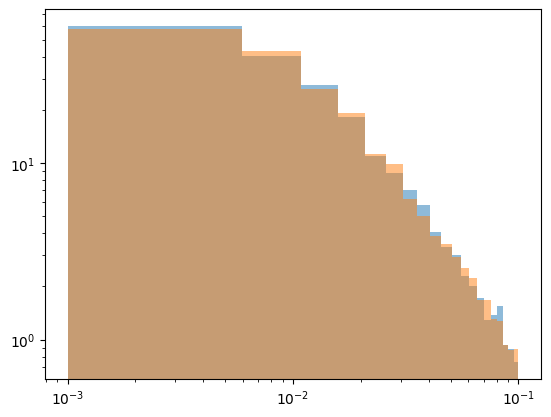

In [14]:
# Do SciPy and EMTK generate the same curve for a Lorentzian?
nevents = 10000
newLorentzian = emtk.lorentzianCurve()
newLorentzian.generateTestSamples(np.array([peak_width]), setxrange, nevents)
emtkdata = newLorentzian.data

scipydata = spGenerator(reference_model, nevents, setxrange)

plt.hist(scipydata, range=setxrange, bins=20, density=True, alpha=0.5)
plt.hist(emtkdata, range=setxrange, bins=20, density=True, alpha=0.5)
plt.xscale('log')
plt.yscale('log')

A human would look at this and say they are the same distribution.  Next the statistical tests.

In [23]:
# Do the statistical tests agree that these are from the same distribution?
# The null hypothesis is that they are from the same distribution.
# We will assume a confidence level of 95%, that is rejecting the null hypothesis with a
# p-value below 0.05.
# The two-sample Kolmogorov-Smirnov test is then:
stat, kspval = stats.ks_2samp(emtkdata, scipydata)
print(kspval)

# likewise with the Cramer Von Mises test statistic (same cutoffs and logic)
res = stats.cramervonmises_2samp(emtkdata, scipydata)
cvmpval = res.pvalue
print(cvmpval)

0.6160853764303585
0.7474803645914645


Indeed this is fine.  Both p-values are way above 0.05 so we are good.  What is going wrong with the 1-sample tests being compared to the cdf functions?

In [30]:
# Let's try the 1-sample tests
stat, ks1pval = stats.ks_1samp(emtkdata, stats.halfcauchy.cdf, args=(peak_location, peak_width))
print(ks1pval)
stat, ks1pval = stats.ks_1samp(scipydata, stats.halfcauchy.cdf, args=(peak_location, peak_width))
print(ks1pval)

# Is it because of the truncation?
untrunc = reference_model.rvs(10000)
stat, ks1pval = stats.ks_1samp(untrunc, stats.halfcauchy.cdf, args=(peak_location, peak_width))
print(ks1pval)

1.2533984269178017e-43
3.591377507868669e-44
0.25402277842640164


So we see that the bad test statistics for 1 sample tests are caused by the fact that we are truncating our data to fall into a particular x-range.  Generating the same number of points without truncation leads to a sensible test result.
**The solution**: generate a synthetic data set in the same x-range and use the 2-sample tests to identify the curve shape.  This is quite exciting I think.

In [36]:
# Testing the methodology for different numbers of data points

bigdata = spGenerator(reference_model, 10000, setxrange)
smalldata= spGenerator(reference_model, 1000, setxrange)
stat, kspval = stats.ks_2samp(smalldata, bigdata)
print(kspval)




0.4858516228848642


In [115]:

def findSANSmodel(events, verbose=True, threshold = 0.95):
    '''
    Tries to identify plausible models that fit a given data set,
    using a statistically rigorous method.
    
    There is a finite probability that this can fail to identify the curve even when the data
    is actually drawn from one of the candidate distributions.  It's therefore best to run it 
    a few times in that situation to be sure that the curve type is definitely not found.
    
    First, the curves are fit with maximum likelihood estimation.
    
    Second, the two sample Kolmogorov-Smirnov test is applied, comparing the data
    with synthetic data generated from each analytical curve type.
    
    Finally, the plausible curves are ranked and feedback is given as to which,
    if any, are likely to be a good description of the data.
    
    Parameters:
        data:
            A numpy array of float x-values (Q, Angstroms)
        verbose:
            A boolean (optional) as to whether to output any information, or just return the result
        threshold:
            A float (optional) representing the confidence value to use for the null hypothesis rejection
    Outputs:
        Summary of the findings, listing all plausible curves and their metrics.
        
    Returns:
        A string with the name of the distribution that best matches the data.
    '''
    
    # Setup x-range
    xmin = np.amin(events) # Maybe quantiles is eventually best here, if there are outliers?
    xmax = np.amax(events) 
    xrange = np.array([xmin, xmax])

    
    # setup results
    ksarray = np.empty(0)
    namearray = list()
    candidateFound = False
    pmin = 1.0-threshold
    
    
    # Test for Lorentzian
    lor = emtk.lorentzianCurve()
    lor.data = events
    lor.setupGuesses()
    lor.mle()
    
    params = lor.estimates
    
    lor2 = emtk.lorentzianCurve()
    lor2.generateTestSamples(params, xrange, 1000)
    
    lor2data = lor2.data
    
    stat, lorks = stats.ks_2samp(events, lor2data)
    
    ksarray = np.append(ksarray, np.array(lorks))
    namearray.append("Lorentzian")
    
    
    # Test for hard spheres
    hard = emtk.hardSphereCurve()
    hard.data = events
    hard.setupGuesses()
    hard.mle()
    
    params = hard.estimates
    
    hard2 = emtk.hardSphereCurve()
    hard2.generateTestSamples(params, xrange, 1000)
    hard2data = hard2.data
    
    stat, hardks = stats.ks_2samp(events, hard2data)

    ksarray = np.append(ksarray, np.array(hardks))
    namearray.append("Hard spheres")
    
    
    # Test for fractal Porod
    pord = emtk.porodCurve()
    pord.data = events
    pord.setupGuesses()
    pord.mle()
    
    params = pord.estimates
    
    pord2 = emtk.porodCurve()
    pord2.generateTestSamples(params, xrange, 1000)
    pord2data = pord2.data
    
    stat, pordks = stats.ks_2samp(events, pord2data)
    
    ksarray = np.append(ksarray, np.array(pordks))
    namearray.append("Porod")
    
    
    
    
    # Identify most likely answer
    bestloc = np.argmax(ksarray)
    bestname = namearray[bestloc]
    bestval = ksarray[bestloc]
    
    # Get top 3 other candidate curves in order
    topcandidates = np.argsort(ksarray)[::-1] # That last bit reverses the order
    
    if topcandidates.size > 4:
        topcandidates = topcandidates[:4]
        
    if verbose:
        print()
        print("********************************************")
        print("*                                          *")
        print("*    RIGOROUS SANS CURVE IDENTIFICATION    *")
        print("*    ==================================    *")
        print("*                                          *")
        print("* Using maximum likelihood estimation and  *")
        print("* the Kolmogorov-Smirnov two sample test   *")
        print("********************************************")
        print()
        if bestval > pmin:
            candidateFound = True
            print("The most likely curve is a", bestname, "( p-value =", bestval, ")")
            if topcandidates.size > 1:
                print("Next best candidate curves:")
                for i in np.arange(1, topcandidates.size):
                    if ksarray[topcandidates[i]] < 0.05:
                        condstr = "FAILED"
                    else:
                        condstr = ""
                    print("  ", namearray[topcandidates[i]], "(", condstr, "p-value =", ksarray[topcandidates[i]], ")")
        else:
            print("No satisfactory model was found.")
    
    if candidateFound:
        return bestname
    
    return "No model"
    
findSANSmodel(smalldata)

Generated 1000 samples using parameters [0.01070063]
Generated 1000 samples using parameters [89.2637215]
Calculating best minimal value for power law fit
Generated 1000 samples using parameters [2.93228811 0.02536419]

********************************************
*                                          *
*    RIGOROUS SANS CURVE IDENTIFICATION    *
*    ==================================    *
*                                          *
* Using maximum likelihood estimation and  *
* the Kolmogorov-Smirnov two sample test   *
********************************************

The most likely curve is a Lorentzian ( p-value = 0.9969602438295625 )
Next best candidate curves:
   Hard spheres ( FAILED p-value = 4.0687670654048253e-07 )
   Porod ( FAILED p-value = 2.432149587982038e-292 )


'Lorentzian'

### Repeat the Variance Experiment in SANS Regime

<AxesSubplot: >

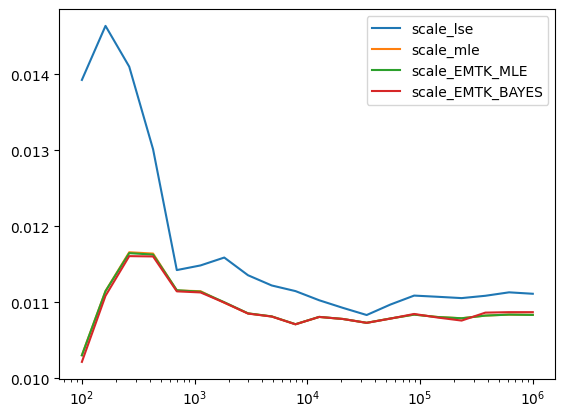

In [7]:
# peak function
peak_location = 0.0
peak_width = 1.0 / 90.0
setxrange = [0.001,0.1]

def compare_cauchy(nevents, loc=peak_location, scale=peak_width, xrange=setxrange, seed=None, nbins=None, 
                   legend=False, model_plot=False):
    mle_fit_model = stats.distributions.cauchy
    lse_fit_model = models.LorentzianModel()
    reference_model = mle_fit_model(loc=loc, scale=scale)
    emtk_model = emtk.lorentzianCurve()
    bayes_model = emtk.lorentzianCurve()
    parameters = compare(reference_model, mle_fit_model, lse_fit_model, emtk_model, bayes_model, nevents=nevents, xrange=xrange, 
                         nbins=nbins, seed=seed, legend=legend, model_plot=model_plot)
    return parameters

data = {nevents: compare_cauchy(nevents, seed=333, model_plot=False) for nevents in [int(n) for n in np.logspace(2, 6, 20)]}

pd_data = pd.DataFrame(data).T

pd_data.plot(logx=True)

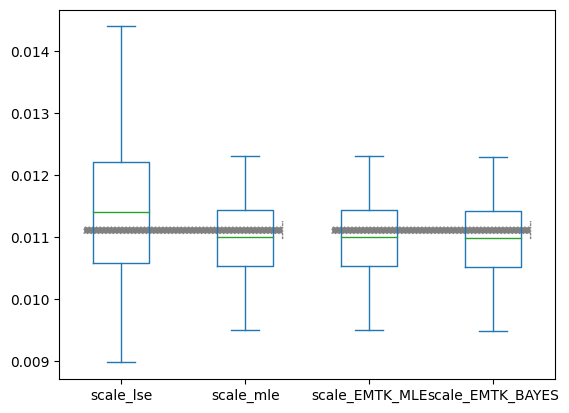

In [8]:
# Run multiple fittings with same number of events but different seeds

nruns = 50
nevents = 500

np.random.seed(0)
seeds = np.random.randint(0, high=10**4, size=nruns)

data = {seed: compare_cauchy(nevents=nevents, seed=seed, model_plot=False) for seed in seeds}

pd_data = pd.DataFrame(data).T


ax = pd_data[['scale_lse', 'scale_mle', 'scale_EMTK_MLE', 'scale_EMTK_BAYES']].plot.box()
ax.arrow(0.7, peak_width, 1.6, 0, linestyle='dotted', color='gray', width=0.0001)
ax.arrow(2.7, peak_width, 1.6, 0, linestyle='dotted', color='gray', width=0.0001)

In [9]:
# Variance vs number of events (this one takes a while...)

nruns = 50

np.random.seed(0)
seeds = np.random.randint(0, high=10**4, size=nruns)

def get_variance(nevents):
    data = pd.DataFrame({seed: compare_cauchy(nevents=nevents, seed=seed) for seed in seeds})
    return data.mean(axis=1), data.std(axis=1)

nevents_series = [int(n) for n in np.logspace(2, 6, 20)]

results = {nevents: get_variance(nevents) for nevents in nevents_series}

means = {nevents: res[0] for nevents, res in results.items()}
pd_means = pd.DataFrame(means).T

pd_means.head()

,scale_lse,scale_mle,scale_EMTK_MLE,scale_EMTK_BAYES
100,0.011648,0.010910,0.010911,0.010815
162,0.011408,0.010938,0.010939,0.010879
263,0.011467,0.011062,0.011063,0.011025
428,0.011460,0.010957,0.010956,0.010933
695,0.011444,0.010955,0.010955,0.010941


In [10]:
stds  = {nevents: res[1] for nevents, res in results.items()}
pd_stds = pd.DataFrame(stds).T
pd_stds.head()

,scale_lse,scale_mle,scale_EMTK_MLE,scale_EMTK_BAYES
100,0.002344,0.001464,0.001466,0.001454
162,0.001587,0.001126,0.001127,0.001120
263,0.001322,0.000919,0.000918,0.000915
428,0.001144,0.000687,0.000687,0.000686
695,0.000853,0.000550,0.000548,0.000548


In [11]:
def get_data_for_plot(key):
    x = pd_means.index.array
    y = pd_means[key].array
    dy = pd_stds[key].array
    return (x, y), (x, y - 2*dy, y + 2*dy)

def variance_plot(key, ax):
    ax.set_xscale('log')
    line, fill = get_data_for_plot(key)
    ax.fill_between(*fill, alpha=0.25)
    ax.plot(*line)


Text(0.5, 0.01, '#events')

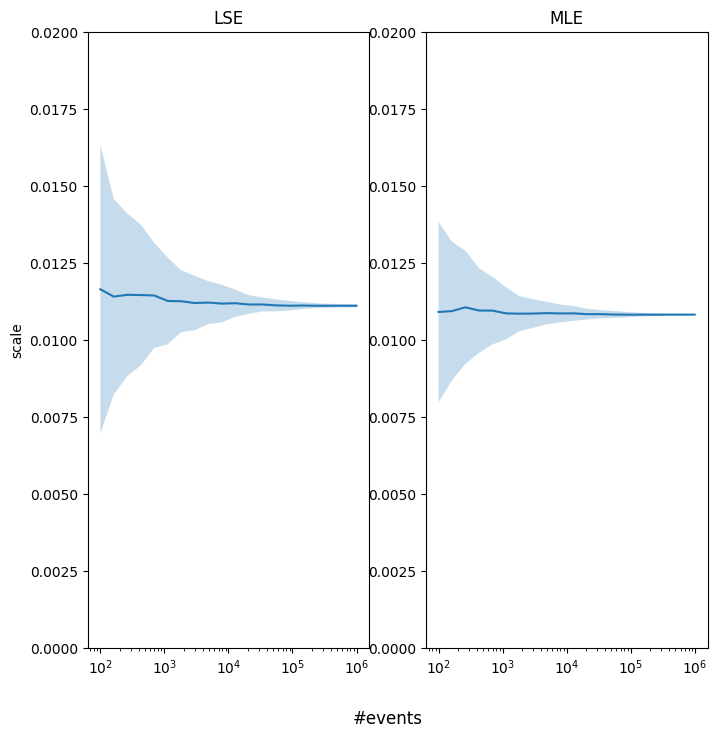

In [20]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(8, 8))

#axs[0,0].set_ylim(-0.015, 0.015)
#axs[0,1].set_ylim(-0.015, 0.015)
axs[0].set_ylim(0.0, 0.02)
axs[1].set_ylim(0.0, 0.02)

axs[0].set_title("LSE")
axs[1].set_title("MLE")

axs[0].set_ylabel("scale")
axs[0].set_ylabel("scale")


#variance_plot('loc_lse', axs[0,0])
#variance_plot('loc_mle', axs[0,1])
variance_plot('scale_lse', axs[0])
variance_plot('scale_mle', axs[1])

fig.supxlabel('#events')
#fig.supylabel('parameters')